In [1]:
import gc
import hashlib
import json
import os
from collections import Counter
from typing import Callable, List, Optional, Tuple

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import pickle as pk
import random

In [2]:
with open("../templates/metadata_w_examples.json") as f:
    metadatas = json.load(f)

In [3]:
def get_extension(s: str) -> str:
    return s.split(".")[-1]


template_directory = "../templates/template_data/"
example_directory = "../templates/template_examples/"

_X, _Y = [], []

templates = set(os.listdir(template_directory))
examples = set(os.listdir(example_directory))
for metadata in metadatas:
    template_file = metadata["html_file"] + "." + get_extension(metadata["src"])
    template_id = metadata["Template ID"]

    # Process template
    if template_file not in templates:
        raise Exception(f"CAN NOT FIND TEMPLATE: {template_file}")

    template_path = os.path.join(template_directory, template_file)
    _X.append(os.path.abspath(template_path))
    _Y.append(template_id)

    # Process examples
    for example in metadata["examples"]:
        byte_string = example["title"].encode()
        md5_hash = hashlib.md5(byte_string).hexdigest()
        ext = get_extension(example["url"])

        example_filename = f"{md5_hash}_{template_id}.{ext}"
        example_path = os.path.join(example_directory, example_filename)

        if example_filename not in examples:
            raise Exception(f"CAN NOT FIND EXAMPLE: {example_filename}")

        _X.append(os.path.abspath(example_path))
        _Y.append(template_id)


X_data, Y_data = np.array(_X), np.array([int(y) for y in _Y])
X_data.shape, Y_data.shape

((20584,), (20584,))

(5113,) (34,)


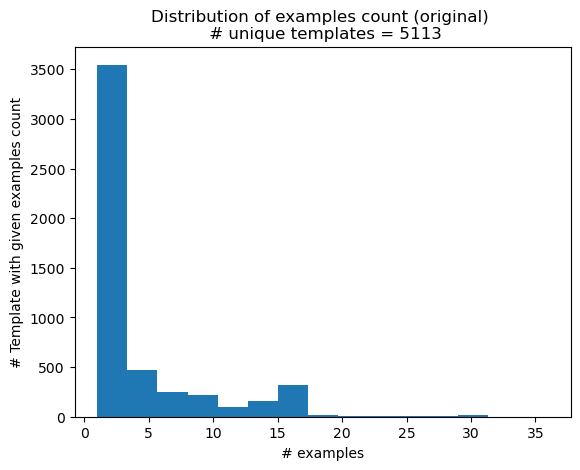

In [4]:
count = Counter(Y_data)
print(np.unique(Y_data).shape, np.unique(list(count.values())).shape)
plt.hist(count.values(), bins=15)
plt.xlabel("# examples")
plt.ylabel("# Template with given examples count")
plt.title(
    f"Distribution of examples count (original) \n # unique templates = {len(np.unique(Y_data))}"
)
plt.savefig("./outputs/Distribution of examples count (original)")

In [5]:
Counter([get_extension(i) for i in X_data])

Counter({'gif': 15471, 'mp4': 5113})

In [6]:
# data = [X_data, Y_data]
# with open("./data/data.pkl", "wb") as f:
#     pk.dump(data, f)

# Sample data so that dataset is more balance

In [7]:
with open("./data/data.pkl", "rb") as f:
    X_data, Y_data = pk.load(f)


def sample(data: list, n: int = 40):
    res = []
    count = {}
    added_idx = set()

    for _ in range(len(data) * n):
        i = random.randint(0, len(data) - 1)
        elem = data[i]

        if elem not in count and i not in added_idx:
            res.append(i)
            added_idx.add(i)
            count[elem] = 1
        else:
            if count[elem] > n or i in added_idx:
                continue
            else:
                res.append(i)
                added_idx.add(i)
                count[elem] += 1
    return res


def filter_threshold(data: list, n: int = 5):
    count = Counter(data)
    Y_merged = []
    for i in data:
        if count[i] < n:
            Y_merged.append(0)
        else:
            Y_merged.append(i)

    return np.array(Y_merged)

686 10165


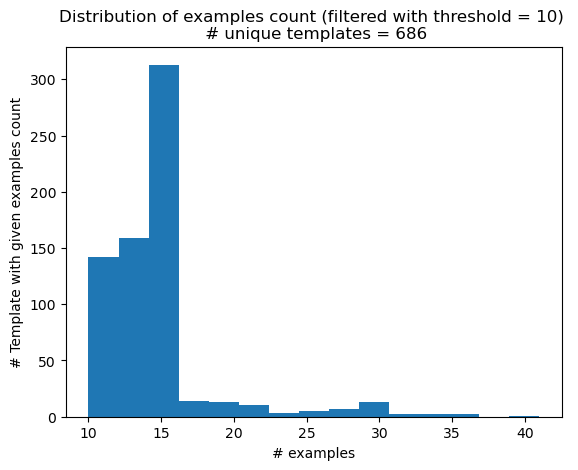

In [11]:
threshold = 10
Y_merged = filter_threshold(Y_data, n=threshold)
idxes = sample(Y_merged)
Y_sampled = Y_merged[idxes]
X_sampled = X_data[idxes]

print(len(np.unique(Y_sampled)), len(Y_sampled))

plt.hist(Counter(Y_sampled).values(), bins=15)
plt.xlabel("# examples")
plt.ylabel("# Template with given examples count")
plt.title(
    f"Distribution of examples count (filtered with threshold = {threshold}) \n # unique templates = {len(np.unique(Y_sampled))}"
)
plt.savefig(
    f"./outputs/Distribution of examples count (filtered with threshold = {threshold}).png"
)

In [12]:
# data = [X_sampled, Y_sampled]
# with open("./data/data_sampled_threshold_10.pkl", "wb") as f:
#     pk.dump(data, f)

(20,) (20,) [306509753 370636203]


(array([1., 0., 0., 1.]),
 array([ 6.,  8., 10., 12., 14.]),
 <BarContainer object of 4 artists>)

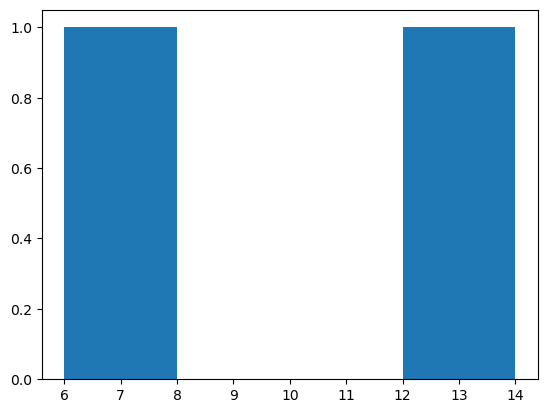

In [2]:
with open("./data/data_sampled.pkl", "rb") as f:
    X_data, Y_data = pk.load(f)

count = Counter(Y_data)
# print(count)

idxes = []
template_id = set(
    [
        370636203,
        306509753,
    ]
)  # 416346667, 418256352])
while len(idxes) < 20:
    idx = random.randint(0, len(Y_data) - 1)
    if Y_data[idx] not in template_id:
        continue

    idxes.append(idx)

Y_smol = Y_data[idxes]
X_smol = X_data[idxes]

print(X_smol.shape, Y_smol.shape, np.unique(Y_smol))
plt.hist(Counter(Y_smol).values(), bins=4)

In [6]:
data = [X_smol, Y_smol]
with open("./data/data_sampled_smol_2.pkl", "wb") as f:
    pk.dump(data, f)